In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils

from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, cross_val_score, \
        cross_val_predict, learning_curve, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, r2_score, mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# read in the data we previously processed
df_train = pd.read_csv('band_gap_data/df_train.csv')
df_metal_train = pd.read_csv('band_gap_data/df_metal_train.csv')

# convert the convert the target to non-metal (target=0)
df_train['target'] = np.zeros(len(df_train))
# convert the target to metal (target=1)
df_metal_train['target'] = np.ones(len(df_metal_train))

# combine the data into an X_train matrix and y_train vector
formula = pd.concat([df_train.iloc[:,1:], df_metal_train.iloc[:,1:]], ignore_index=True)
X_train = pd.concat([df_train.iloc[:,1:-1], df_metal_train.iloc[:,1:-1]], ignore_index=True)
y_train = pd.concat([df_train.iloc[:,-1], df_metal_train.iloc[:,-1]], ignore_index=True)

In [4]:
rf = RandomForestClassifier(n_estimators=200)
cv = KFold(n_splits=3, random_state=13)
y_pred = cross_val_predict(X=X_train, y=y_train, cv=cv, estimator=rf)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

        0.0       0.84      0.90      0.87      1938
        1.0       0.87      0.80      0.83      1646

avg / total       0.85      0.85      0.85      3584



In [8]:
# we now want to process our data. We are going to use the SVR algorithm.
# This algorithm is based on gradient descent and needs similar feature scales.

# scale each column of data to have a mean of 0 and a variance of 1
scaler = StandardScaler()
# normalizes each row in the data
normalizer = Normalizer()
# perform the scaling/normalizing
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(normalizer.fit_transform(X_train_scaled), columns=X_train.columns.values)

In [9]:
# Create correlation matrix
corr_matrix = X_train_scaled.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [10]:
# Find index of feature columns with correlation less than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.35)]
to_keep = [column for column in X_train_scaled.columns if column not in to_drop]
X_train_reduced = X_train_scaled[to_keep]
X_train_reduced.shape

(3584, 41)

In [11]:
rf = RandomForestClassifier(n_estimators=200)
y_pred = cross_val_predict(X=X_train_reduced, y=y_train, cv=cv, estimator=rf)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

        0.0       0.72      0.77      0.74      1938
        1.0       0.71      0.65      0.68      1646

avg / total       0.71      0.71      0.71      3584



Feature ranking:
1. feature 1 (0.258) : sum_C-10
2. feature 0 (0.231) : sum_C-0
3. feature 40 (0.118) : var_ndvalence


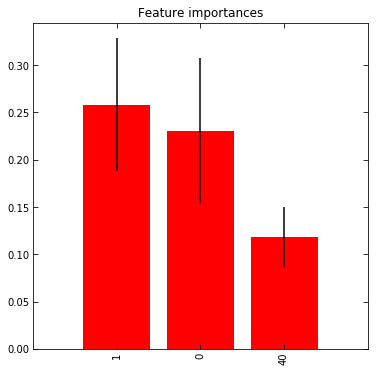

In [12]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_reduced, y_train)
important_feature = utils.rf_feature_importance(rf, X_train_reduced, N=3, std_deviation=True)

In [13]:
X_important = X_train_reduced.loc[:,important_feature]
X_important.head()

,sum_C-10,sum_C-0,var_ndvalence
0,0.007144,-0.049231,0.040409
1,0.004099,-0.014049,-0.028641
2,0.000576,-0.017692,0.003092
3,0.053938,-0.012719,0.027330
4,0.003645,-0.031258,0.025365


Feature ranking:
1. feature 0 (0.397) : sum_C-10
2. feature 1 (0.357) : sum_C-0
3. feature 2 (0.246) : var_ndvalence


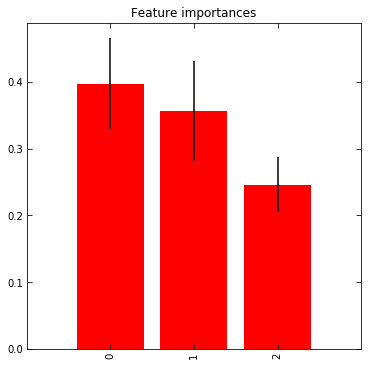

In [16]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_important, y_train)
important_feature = utils.rf_feature_importance(rf, X_important, N='all', std_deviation=True)

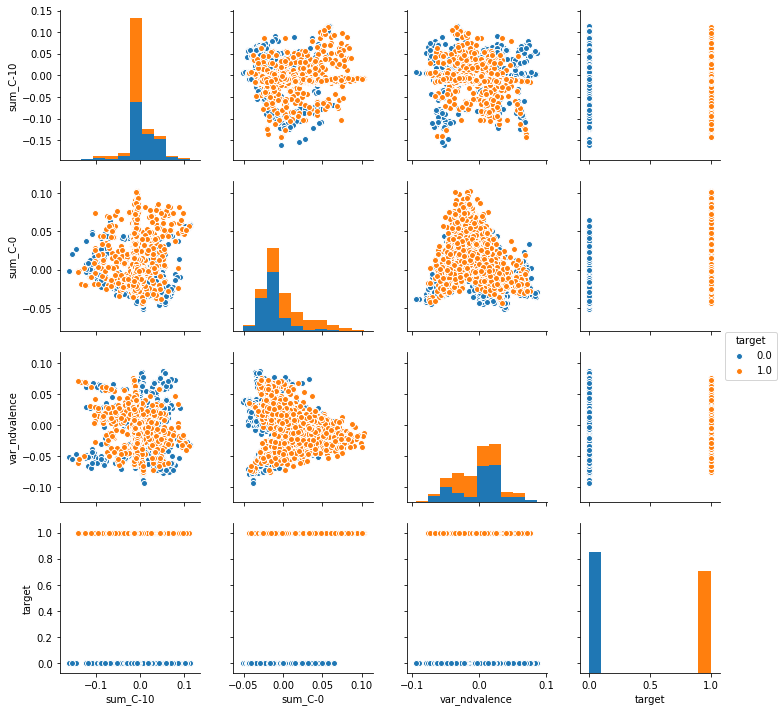

In [19]:
X_train_reduced = X_important.copy()
X_train_reduced['target'] = y_train
sns.pairplot(X_train_reduced, hue='target')

In [26]:
# We will want to reduce our feature space to make learning easier
pca = PCA(n_components=70)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled))

In [27]:
rf = RandomForestClassifier(n_estimators=200)
y_pred = cross_val_predict(X=X_train_pca, y=y_train, cv=cv, estimator=rf)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

        0.0       0.76      0.82      0.79      1938
        1.0       0.77      0.69      0.73      1646

avg / total       0.76      0.76      0.76      3584



Feature ranking:
1. feature 0 (0.221) : 0
2. feature 1 (0.101) : 1
3. feature 9 (0.052) : 9
4. feature 8 (0.045) : 8
5. feature 2 (0.043) : 2
6. feature 3 (0.037) : 3
7. feature 6 (0.034) : 6
8. feature 5 (0.032) : 5
9. feature 7 (0.031) : 7
10. feature 10 (0.027) : 10
11. feature 11 (0.027) : 11
12. feature 16 (0.025) : 16
13. feature 4 (0.023) : 4
14. feature 14 (0.022) : 14
15. feature 26 (0.021) : 26
16. feature 12 (0.020) : 12
17. feature 18 (0.019) : 18
18. feature 19 (0.019) : 19
19. feature 21 (0.019) : 21
20. feature 17 (0.018) : 17
21. feature 22 (0.018) : 22
22. feature 24 (0.018) : 24
23. feature 28 (0.017) : 28
24. feature 20 (0.017) : 20
25. feature 29 (0.016) : 29
26. feature 27 (0.015) : 27
27. feature 15 (0.015) : 15
28. feature 23 (0.015) : 23
29. feature 13 (0.015) : 13
30. feature 25 (0.015) : 25


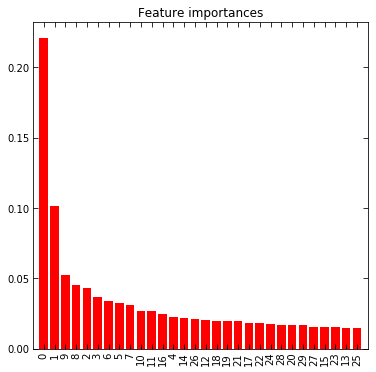

In [23]:
rf.fit(X_train_pca, y_train)
important_feature = utils.rf_feature_importance(rf, X_train_pca, N='all')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


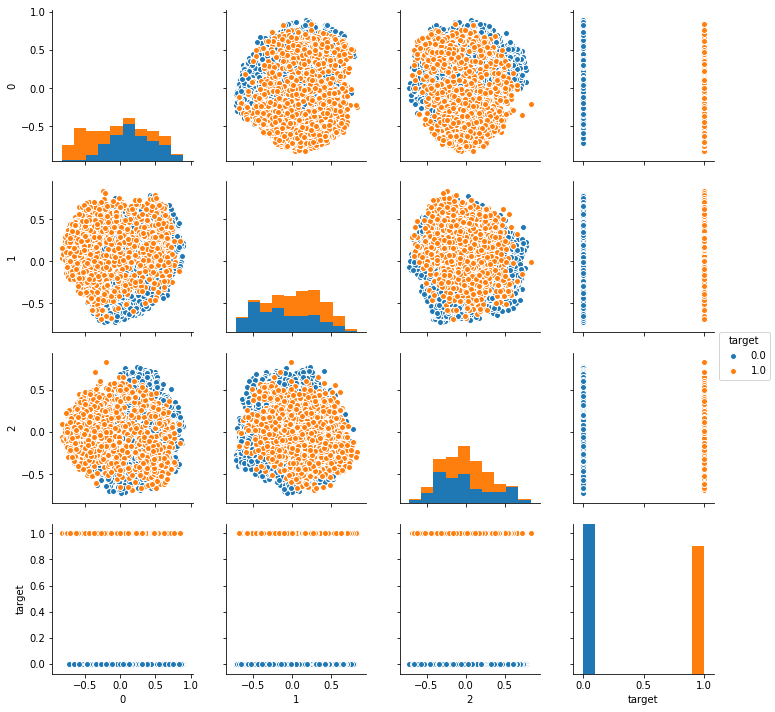

In [24]:
df_pca = X_train_pca[[0, 1, 2]]
df_pca['target'] = y_train
sns.pairplot(df_pca, hue='target')

KeyError: '[ 0  1  9  8  2  3  6  5  7 10 11 16  4 14 26 12 18 19 21 17 22 24 28 20\n 29 27 15 23 13 25] not in index'